# Time Series - Consumo Eletricidade

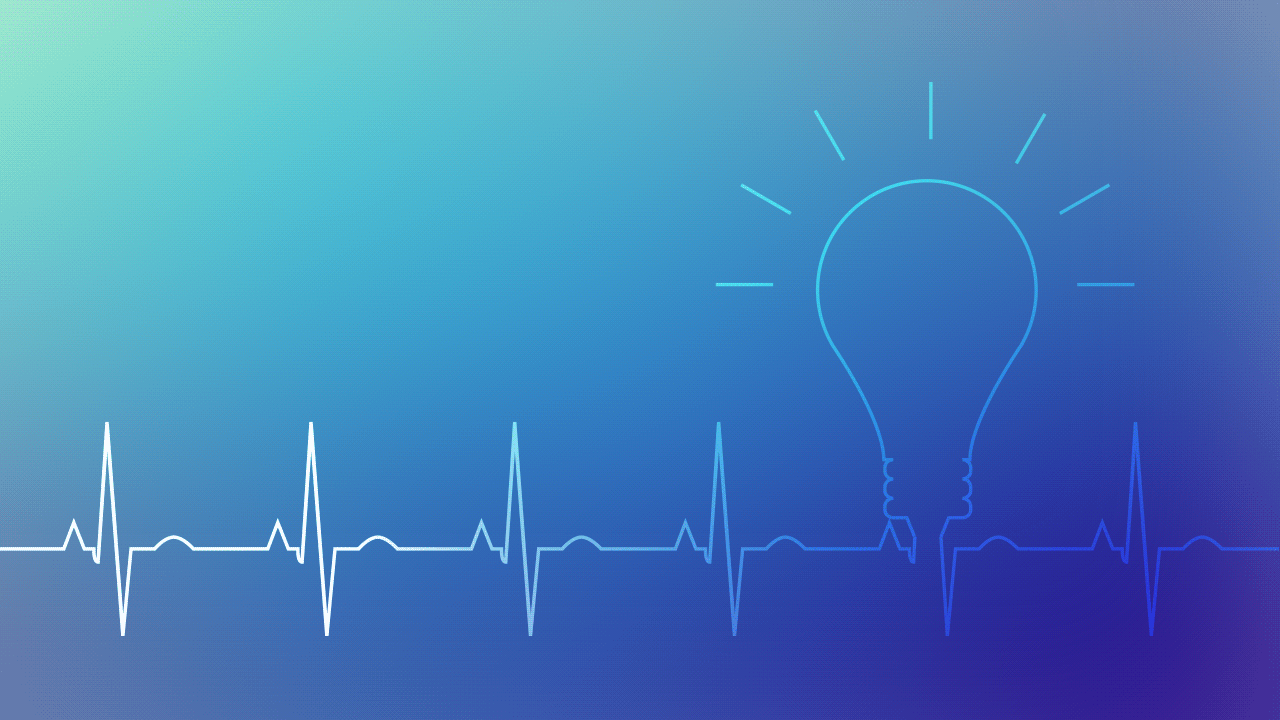

- https://github.com/nageshsinghc4/
- https://towardsdatascience.com/predict-electricity-consumption-using-time-series-analysis-4650284e40aa

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Utilização do estilo do Five Thirty Eight
plt.style.use('fivethirtyeight')

from pylab import rcParams
rcParams['figure.figsize'] = 10, 6

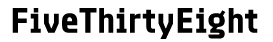
- https://fivethirtyeight.com/
- https://www.amazon.com.br/Ru%C3%ADdo-Tantas-Previs%C3%B5es-Falham-Outras/dp/8580573467/

In [2]:
df = pd.read_csv('Electric_Production.csv')

In [3]:
df.columns=['Date', 'Consumption']

# drop de dados faltantes
df=df.dropna()
df['Date'] = pd.to_datetime(df['Date'])

# a Data passar a ser o índice
df.set_index('Date', inplace=True) #set date as index
df.head()

,Consumption
Date,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


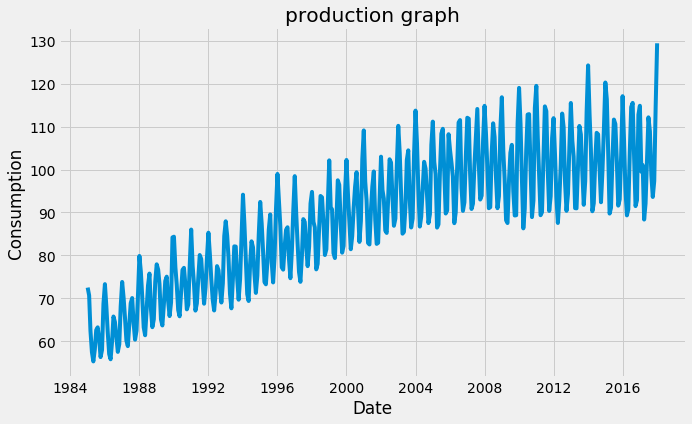

In [4]:
# Plot dos dados
plt.xlabel("Date")
plt.ylabel("Consumption")
plt.title("production graph")
plt.plot(df)

Dado que a média não parece ser constante será necessário realizar alguma transformação para tornar a curva estacionária

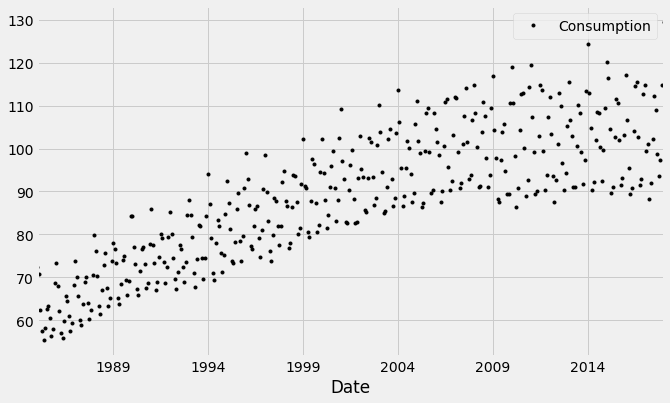

In [5]:
#scatter plot dos dados
df.plot(style='k.')
plt.show()

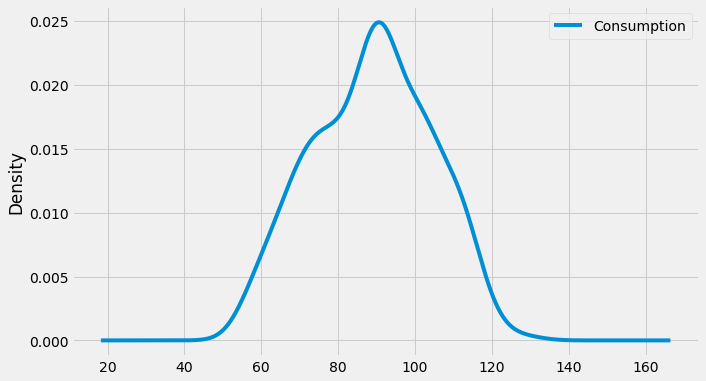

In [6]:
# Verificação da distribuição dos dados
df.plot(kind='kde')

In [7]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    # Estatísticas da Média Móvel
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    # Plot dos dados móveis (rolling)
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)   

In [8]:
# Teste Dickey Fuller  
print("Results of dickey fuller test")
adft = adfuller(df['Consumption'],autolag='AIC')

output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])

for key,values in adft[4].items():
    output['critical value (%s)'%key] =  values
print(output)

Results of dickey fuller test
Test Statistics                 -2.256990
p-value                          0.186215
No. of lags used                15.000000
Number of observations used    381.000000
critical value (1%)             -3.447631
critical value (5%)             -2.869156
critical value (10%)            -2.570827
dtype: float64


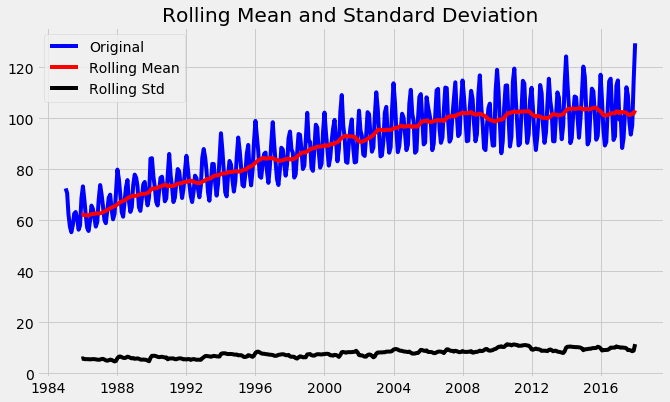

In [9]:
# Execução da função para verificar se os dados são estacionários
test_stationarity(df)

## Eliminação da tendência

Uma técnica muito utilizada para reduzer a tendência e aplicar o log à série para reduzir a magnitude dos valores e diminuir a inclinação dos dados no gráfico. Iremos também calcular a média móvel da série.

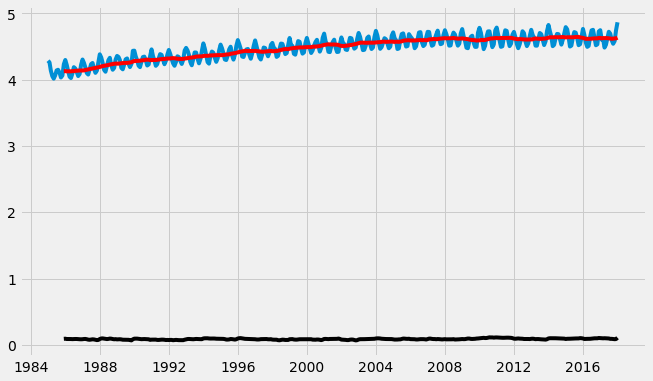

In [10]:
# Cálculo do Log
df_log = np.log(df)
# Média Móvel
moving_avg = df_log.rolling(12).mean()
# Desvio Padrão Móvel
std_dev = df_log.rolling(12).std()
# Plot dos novos dados
plt.plot(df_log)
plt.plot(moving_avg, color="red")
plt.plot(std_dev, color ="black")
plt.show()

Podemos eliminar a tendência fazendo a diferenciação dos dados (log) pela média, eliminado a tendência.

## Diferenciação: Log - Média Móvel

In [11]:
# Diferenciação
df_log_moving_avg_diff = df_log-moving_avg
# Drop dos NaN
df_log_moving_avg_diff.dropna(inplace=True)

Visualização da transformação

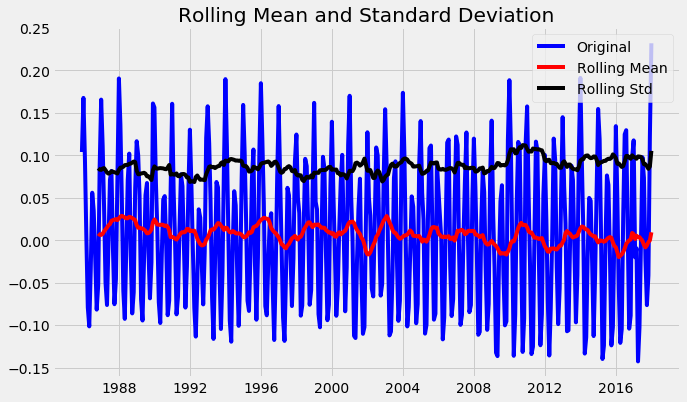

In [12]:
test_stationarity(df_log_moving_avg_diff)

In [13]:
# Teste Dickey Fuller  
print("Results of dickey fuller test")
adft = adfuller(df_log_moving_avg_diff,autolag='AIC')

output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])

for key,values in adft[4].items():
    output['critical value (%s)'%key] =  values
print(output)

Results of dickey fuller test
Test Statistics                 -5.211586
p-value                          0.000008
No. of lags used                15.000000
Number of observations used    370.000000
critical value (1%)             -3.448148
critical value (5%)             -2.869383
critical value (10%)            -2.570948
dtype: float64


## Suavização: Exponential Weighted Average

A suavização exponencial, dos pesos ponderados, também pode ser utilizada para estacionar os dados - função ewm()

In [14]:
weighted_average = df_log.ewm(halflife=12, min_periods=0,adjust=True).mean()
print(weighted_average.head())

            Consumption
Date                   
1985-01-01     4.283658
1985-02-01     4.270484
1985-03-01     4.222468
1985-04-01     4.175897
1985-05-01     4.139460


A exponential moving average (EMA) é uma média ponderada dos últimos n preços onde o peso diminui exponencialmente com cada passo da série. Ou seja, preços recentes tem um peso maior do que pesos antigos.

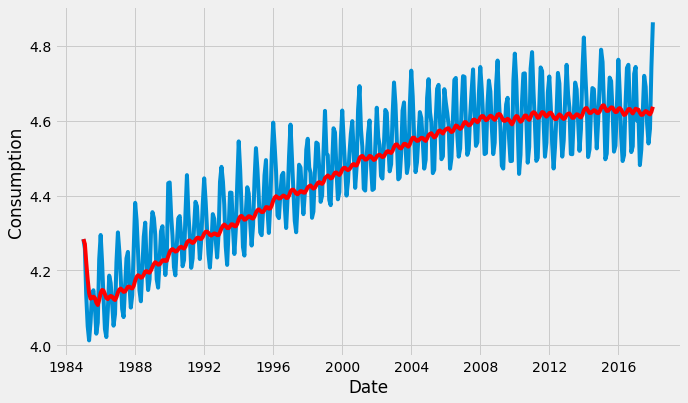

In [15]:
plt.plot(df_log)
plt.plot(weighted_average, color='red')
plt.xlabel("Date")
plt.ylabel("Consumption")
from pylab import rcParams
rcParams['figure.figsize'] = 10,6
#plt.legend()
plt.show(block =False)

A exponential moving average (EMA) é uma média ponderada dos últimos n preços onde o peso diminui exponencialmente com cada passo da série. Ou seja, preços recentes tem um peso maior do que pesos antigos.

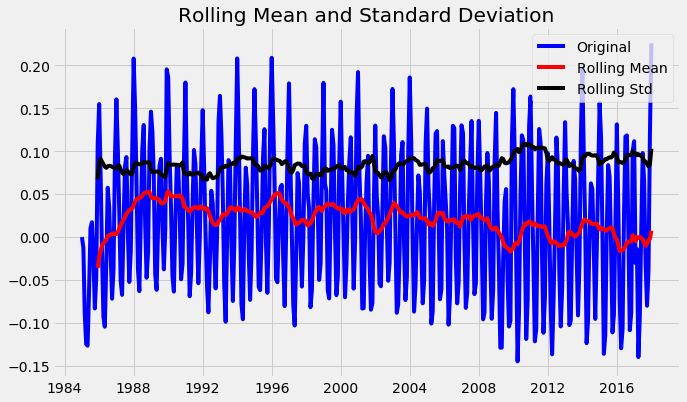

In [16]:
# Subtração do log pelo EMA
logScale_weightedMean = df_log-weighted_average
from pylab import rcParams
rcParams['figure.figsize'] = 10,6
test_stationarity(logScale_weightedMean)

In [17]:
# Teste Dickey Fuller  
print("Results of dickey fuller test")
adft = adfuller(weighted_average,autolag='AIC')

output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])

for key,values in adft[4].items():
    output['critical value (%s)'%key] =  values
print(output)

Results of dickey fuller test
Test Statistics                 -3.577210
p-value                          0.006212
No. of lags used                16.000000
Number of observations used    380.000000
critical value (1%)             -3.447676
critical value (5%)             -2.869176
critical value (10%)            -2.570838
dtype: float64


## Diferenciação dos dados Log

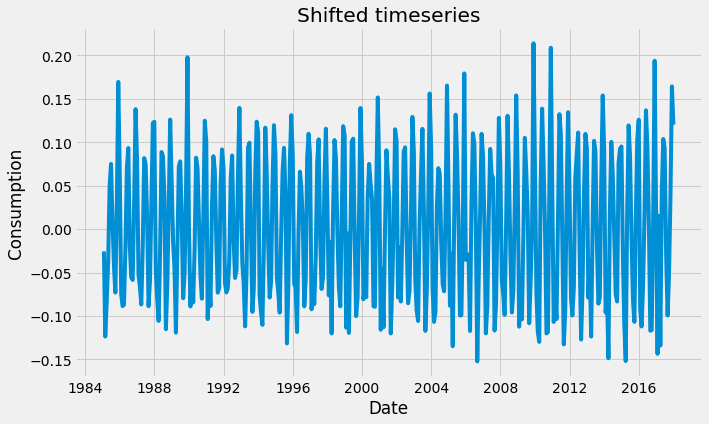

In [18]:
df_log_diff = df_log - df_log.shift()
plt.title("Shifted timeseries")
plt.xlabel("Date")
plt.ylabel("Consumption")
plt.plot(df_log_diff)

In [19]:
# Eliminação dos NaN
df_log_diff.dropna(inplace=True)

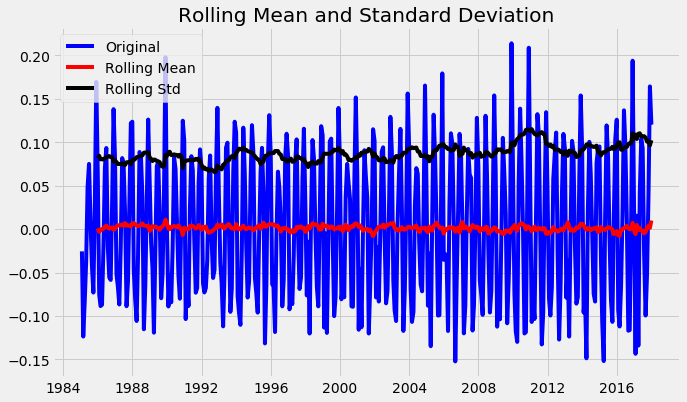

In [20]:
# Visualização -  estacionariedade
test_stationarity(df_log_diff)

In [21]:
# Teste Dickey Fuller  
print("Results of dickey fuller test")
adft = adfuller(df_log_diff,autolag='AIC')

output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])

for key,values in adft[4].items():
    output['critical value (%s)'%key] =  values
print(output)

Results of dickey fuller test
Test Statistics               -6.748333e+00
p-value                        2.995161e-09
No. of lags used               1.400000e+01
Number of observations used    3.810000e+02
critical value (1%)           -3.447631e+00
critical value (5%)           -2.869156e+00
critical value (10%)          -2.570827e+00
dtype: float64


## Decomposição da série com o seasonal_decompose

- Obs: se necessário instalar o chart-studio
- pip install chart-studio

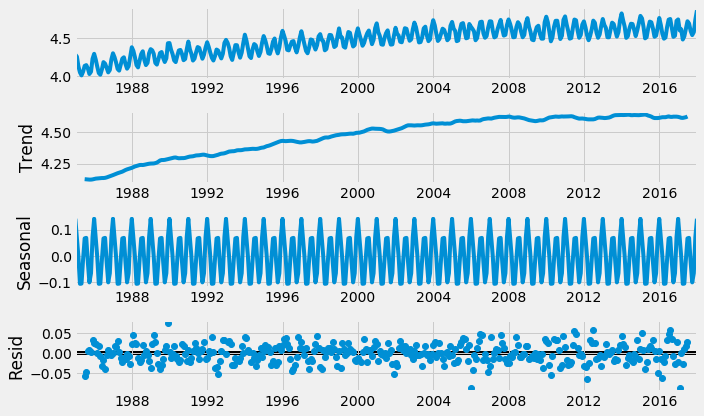

In [23]:
import chart_studio.plotly as py
from chart_studio.plotly import plot_mpl
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df_log, model='additive', freq = 12)
result.plot()
plt.show()

In [24]:
trend = result.trend
trend.dropna(inplace=True)
trend

Date
1985-07-01    4.126457
1985-08-01    4.125300
1985-09-01    4.123534
1985-10-01    4.123062
1985-11-01    4.123117
                ...   
2017-03-01    4.615421
2017-04-01    4.614662
2017-05-01    4.617567
2017-06-01    4.620230
2017-07-01    4.625917
Name: trend, Length: 385, dtype: float64

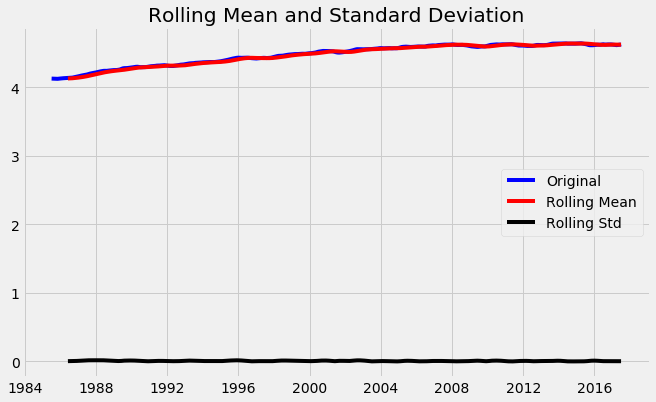

In [25]:
test_stationarity(trend)

In [26]:
seasonality = result.seasonal
seasonality.dropna(inplace=True)
seasonality

Date
1985-01-01    0.142149
1985-02-01    0.066853
1985-03-01   -0.000756
1985-04-01   -0.106579
1985-05-01   -0.105783
                ...   
2017-09-01   -0.025217
2017-10-01   -0.101048
2017-11-01   -0.066002
2017-12-01    0.072225
2018-01-01    0.142149
Name: seasonal, Length: 397, dtype: float64

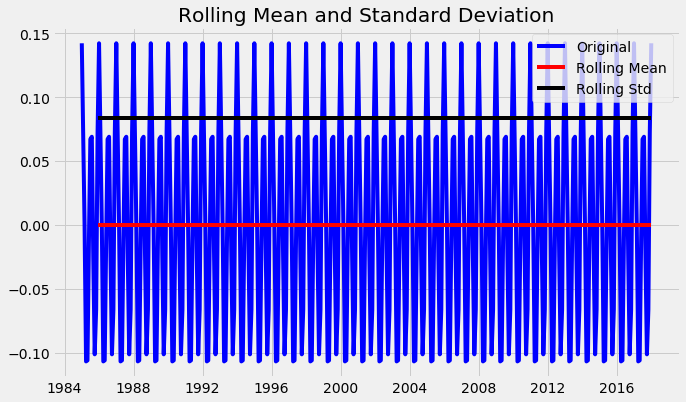

In [27]:
test_stationarity(seasonality)

In [28]:
residual = result.resid
residual.dropna(inplace=True)
residual

Date
1985-07-01   -0.056549
1985-08-01   -0.047294
1985-09-01    0.005724
1985-10-01    0.008954
1985-11-01    0.003336
                ...   
2017-03-01    0.000847
2017-04-01   -0.026743
2017-05-01    0.010879
2017-06-01    0.018331
2017-07-01    0.026774
Name: resid, Length: 385, dtype: float64

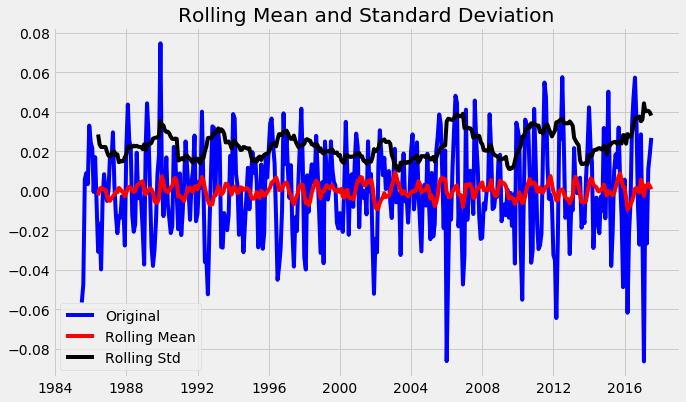

In [29]:
test_stationarity(residual)

## Determinação dos parâmetros do ARIMA (p,d,q)
- p - termo autoregressivo - AR,
- d - diferenciação não sazonal - I I
- q - janela média móvel - MA
- https://rinterested.github.io/statistics/arima.html

Iremos utilizar:
- ACF para determinar o 'q' 
- PACF para determinar o 'p' 

### PANDAS

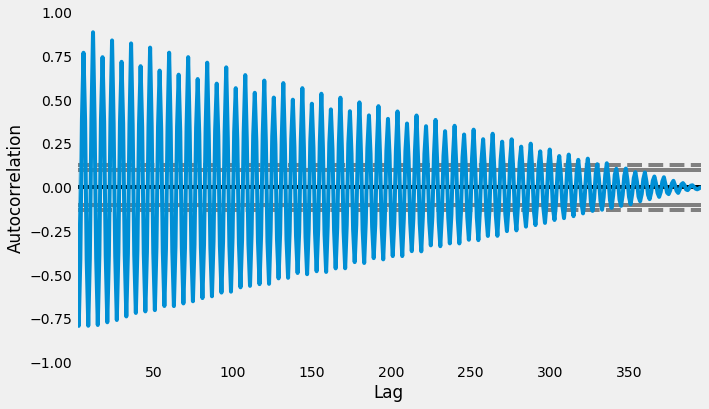

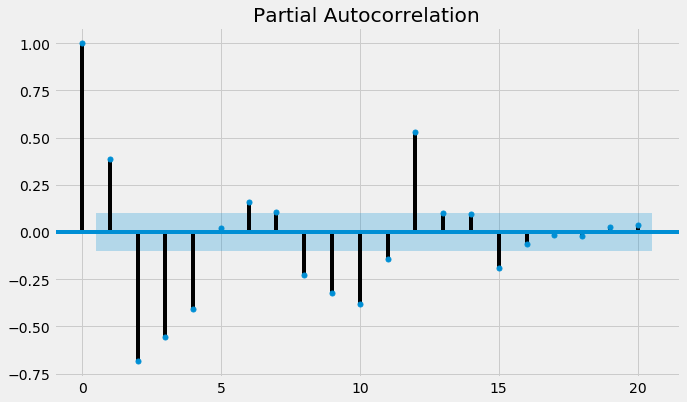

In [30]:
# Geração dos gráficos ACF e PACF - PANDAS
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
autocorrelation_plot(df_log_diff)
plot_pacf(df_log_diff, lags=20)
plt.show()

### STATSMODELS

In [31]:
from statsmodels.tsa.stattools import acf,pacf
# we use d value here(data_log_shift)
acf = acf(df_log_diff, nlags=15)
pacf= pacf(df_log_diff, nlags=15,method='ols')

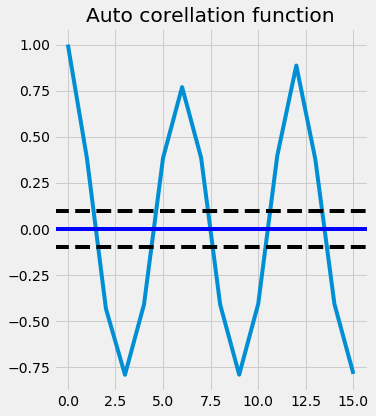

In [32]:
#plot PACF
plt.subplot(121)
plt.plot(acf) 
plt.axhline(y=0,linestyle='-',color='blue')
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='black')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='black')
plt.title('Auto corellation function')
plt.tight_layout()

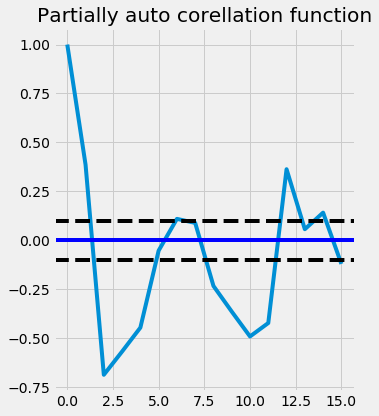

In [33]:
#plot ACF
plt.subplot(122)
plt.plot(pacf) 
plt.axhline(y=0,linestyle='-',color='blue')
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='black')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='black')
plt.title('Partially auto corellation function')
plt.tight_layout()

Geração dos resultados - Sum Square Residuals

In [34]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(df_log, order=(4,1,2))
result_AR = model.fit(disp = 0)
#plt.plot(df_log_diff)
#plt.plot(result_AR.fittedvalues, color='red')
#plt.title("sum of squares of residuals")
print('RSS : %f' %sum((result_AR.fittedvalues-df_log_diff["Consumption"])**2))

C:\Users\afilg\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\afilg\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


RSS : 333.311745


C:\Users\afilg\anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


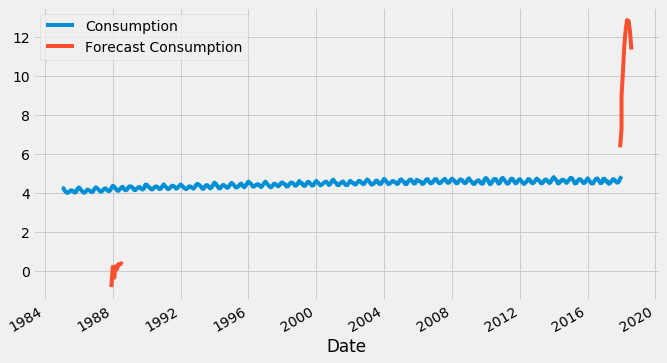

In [38]:
# forecast eletricidade para os próximos 4 meses

# copia dados
future=df_log
# zera índice
future=future.reset_index()
# seleciona a coluna Date
mon=future["Date"]
# faz o offset da data
mon=mon+pd.DateOffset(months=7)
# seleciona últimos registros
future_dates = mon[-7-1:]
# atribui a data como índice
future = future.set_index('Date')
# monta novo dataframe
newDf = pd.DataFrame(index=future_dates, columns=future.columns)
future = pd.concat([future,newDf])
# faz a predição
future["Forecast Consumption"]= result_AR.predict(start=35, end =43, dynamic=True)
# out of sample forecasts
future["Forecast Consumption"].iloc[-10:]=result_AR.forecast(steps=10)[0]
future[['Consumption','Forecast Consumption']].plot()

In [36]:
future

,Consumption,Forecast Consumption
Date,,
1985-01-01,4.283658,NaN
1985-02-01,4.258049,NaN
1985-03-01,4.134369,NaN
1985-04-01,4.051287,NaN
1985-05-01,4.013046,NaN
...,...,...
2018-04-01,NaN,12.385039
2018-05-01,NaN,12.854973
2018-06-01,NaN,12.810254


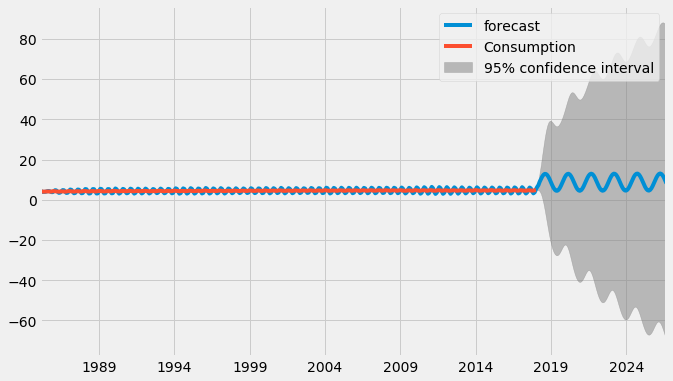

In [39]:
# Predição
result_AR.plot_predict(1,500)
x=result_AR.forecast(steps=200)